### Created by Ali Al Kadhim

### 8-23-2022
-------------

Recall in the previous tutorial (can be found  [here](github.com/AliAlkadhim/NPC_Jets/tree/master/pythia_tutorials/*.pdf) e learned the basic functionalities of pythia, making an event loop, a particle loop, accessing particle methods, filling hisogram and using a card file. In this tutorial we will focus on making jets, using pythia's *SlowJet* program, which is a simpler version of the commonly used *FastJet* jet finder. First let's redo our earlier codes by defining some of the variables, etc. and print the number of particles in each event.

### mymain06.cc: a refersher
Let's use `qcd.cmnd` as our qcd events card:
```
! ---------------------------------------------------------------------
! File: qcd.txt
! Pythia8 commands to simulate pp -> jj + X
! Names are case-insensitive  -  but spelling-sensitive!
! ---------------------------------------------------------------------
! 1)
Main:numberOfEvents   = 10000	   ! number of events to generate/read
Main:timesAllowErrors =  1000      ! abort run after this many flawed events
! ---------------------------------------------------------------------
! 2)
Init:showChangedSettings = on      ! list changed settings
Init:showAllSettings = off         ! list all settings
Init:showChangedParticleData = on  ! list changed particle data
Init:showAllParticleData = off     ! list all particle data
Next:numberCount = 1000            ! print message every n events
Next:numberShowLHA = 1             ! print LHA information n times
Next:numberShowInfo = 1            ! print event information n times
Next:numberShowProcess = 10        ! print process record n times
Next:numberShowEvent = 1           ! print event record n times
Stat:showPartonLevel = on          ! additional statistics on MPI
! ---------------------------------------------------------------------
! 3) Beam parameter settings
Beams:idA = 2212                   ! first beam, p = 2212, pbar = -2212
Beams:idB = 2212                   ! second beam, p = 2212, pbar = -2212
Beams:eCM = 13000.                 ! CM energy of collision (GeV)
!PDF:pSet  = LHAPDF6:CT14nlo	   ! CTEQ 2014 PDF set / need LHAPDF
! ---------------------------------------------------------------------
! 4a) Process
HardQCD:all		= on	   ! g g	-> g g
			  	   ! g g 	-> q qbar  (q = u, d, s)
				   ! q g 	-> q g
				   ! qbar g	-> qbar g
				   ! q q'  	-> q q'
				   ! q qbar'  	-> q qbar'
				   ! qbar qbar'	-> qbar qbar'
				   ! q qbar	-> g g
				   ! q qbar	-> q' qbar'

PhaseSpace:pTHatMin	= 10	   ! minimum pT of parton (GeV)
! ---------------------------------------------------------------------
! 5) Parton level control.
PartonLevel:ISR = on               ! Initial state radiation
PartonLevel:FSR = on               ! Final state radiation
PartonLevel:MPI = on               ! Multiple interactions
! ---------------------------------------------------------------------
HadronLevel:all = on		   ! turn on / off hadronization
! ---------------------------------------------------------------------
Random::setSeed = on
Random:seed     = 31459
```





**mymain06.cc**:
```c
#include "Pythia8/Pythia.h" // Include Pythia headers.
using namespace Pythia8;
int main(int argc, char* argv[]) {
// Set up generation.
Pythia pythia;

// Declare Pythia card file
 pythia.readFile(argv[1]);

pythia.init(); // Initialize; incoming pp beams is default.

// specify the number of events
int nevents = 5;

for (int i=0; i < nevents; i++) {

pythia.next(); // Generate an(other) event. Fill event record.

// calculate the number of particles in the event 
int nparticles = pythia.event.size();
cout << "Event: " << i << endl;
cout << "Event size: " << nparticles << endl;

 //START PARTICLE LOOP
 for (int j = 0; j < nparticles;  j++ ) {
     
    int id = pythia.event[j].id();
}
}
return 0;
}
```

And run with `make mymain06 qcd.cmnd` . Note that instead of puting your loops after `pythia.next()` you can put `if (!pythia.next()) continue;` at the start of the event loop. 

Next, let's learn how to make jets!!

A jet can be initiated as  `SlowJet` object with
`SlowJet Jet( pow, radius, pTjetMin, etaMax);`
where `pow=-1` means using the anti-$k_T$ algorithm, `radius` is the $R$ parameter, `pTjetMin` is the minimum $p_T$ of the jet, and `etaMax` is the maximum $\eta$ which depends on the detector coverage.

Inside the event loop you can find the number of jets in the event by `Jet.analyze(pythia.event);`.

After a lot of digging it seems that the most concise way to do this is in the examples/main73.cc. Which is below:

```c
// Example how to compare "parton-level" and "hadron-level" properties.

#include "Pythia8/Pythia.h"
using namespace Pythia8;

//--------------------------------------------------------------------------

// Generic routine to extract the particles that existed right before
// the hadronization machinery was invoked.

void getPartonLevelEvent( Event& event, Event& partonLevelEvent) {

  // Copy over all particles that existed right before hadronization.
  partonLevelEvent.reset();
  for (int i = 0; i < event.size(); ++i)
  if (event[i].isFinalPartonLevel()) {
	// cout << "the status code of the parton level event is " << event[i].status() << endl;
	
    int iNew = partonLevelEvent.append( event[i] );

    // Set copied properties more appropriately: positive status,
    // original location as "mother", and with no daughters.
    partonLevelEvent[iNew].statusPos();
    partonLevelEvent[iNew].mothers( i, i);
    partonLevelEvent[iNew].daughters( 0, 0);
  }
cout << "END OF THIS EVENT" << endl;
}



// Generic routine to extract the particles that exist after the
// hadronization machinery. Normally not needed, since SlowJet
// contains the standard possibilities preprogrammed, but this
// method illustrates further discrimination.

void getHadronLevelEvent( Event& event, Event& hadronLevelEvent) {

  // Iterate over all final particles.
  hadronLevelEvent.reset();
  for (int i = 0; i < event.size(); ++i) {
    bool accept = false;
    if (event[i].isFinal()) accept = true;

    // Example 1: reject neutrinos (standard option).
    int idAbs = event[i].idAbs();
    if (idAbs == 12 || idAbs == 14 || idAbs == 16) accept = false;

    // Example 2: reject particles with pT < 0.1 GeV (new possibility).
    if (event[i].pT() < 0.1) accept = false;

    // Copy over accepted particles, with original location as "mother".
    if (accept) {
      int iNew = hadronLevelEvent.append( event[i] );
// cout << "the status code of the hadron level event is " << event[i].status() << endl;

      hadronLevelEvent[iNew].mothers( i, i);
    }

  }
cout << "END OF THIS EVENT" << endl;

}

//--------------------------------------------------------------------------

int main() {

  // Number of events, generated and listed ones.
  int nEvent    = 50;
  int nListEvts = 1;
  int nListJets = 5;

  // Generator. LHC process and output selection. Initialization.
  Pythia pythia;
  pythia.readString("Beams:eCM = 13000.");
  pythia.readString("HardQCD:all = on");
  pythia.readString("PhaseSpace:pTHatMin = 200.");
  pythia.readString("Next:numberShowInfo = 0");
  pythia.readString("Next:numberShowProcess = 0");
  pythia.readString("Next:numberShowEvent = 5");
  pythia.init();

  // Parton and Hadron Level event records. Remeber to initalize.
  Event partonLevelEvent;
  partonLevelEvent.init("Parton Level event record", &pythia.particleData);
  Event hadronLevelEvent;
  hadronLevelEvent.init("Hadron Level event record", &pythia.particleData);

  //  Parameters for the jet finders. Need select = 1 to catch partons.
  double radius   = 0.5;
  double pTjetMin = 20.;
  double etaMax   = 4.;
  int select      = 1;

  // Set up anti-kT clustering, comparing parton and hadron levels.
  SlowJet antiKTpartons( -1, radius, pTjetMin, etaMax, select);
  SlowJet antiKThadrons( -1, radius, pTjetMin, etaMax, select);

  // Histograms.
  Hist nJetsP("number of jets, parton level", 50, -0.5, 49.5);
  Hist nJetsH("number of jets, hadron level", 50, -0.5, 49.5);
  Hist pTallP("pT for jets, parton level", 100, 0., 500.);
  Hist pTallH("pT for jets, hadron level", 100, 0., 500.);
  Hist pThardP("pT for hardest jet, parton level", 100, 0., 500.);
  Hist pThardH("pT for hardest jet, hadron level", 100, 0., 500.);
  Hist pTdiff("pT for hardest jet, hadron - parton", 100, -100., 100.);

  // Begin event loop. Generate event. Skip if error.
  for (int iEvent = 0; iEvent < nEvent; ++iEvent) {
    if (!pythia.next()) continue;

    // Construct parton and hadron level event.
    getPartonLevelEvent( pythia.event, partonLevelEvent);
    getHadronLevelEvent( pythia.event, hadronLevelEvent);

    // List first few events.
    if (iEvent < nListEvts) {
      pythia.event.list();
      partonLevelEvent.list();
      hadronLevelEvent.list();
    }

    // Analyze jet properties and list first few analyses.
    antiKTpartons.analyze( partonLevelEvent );
    antiKThadrons.analyze( hadronLevelEvent );
    if (iEvent < nListJets) {
      antiKTpartons.list();
      antiKThadrons.list();
    }

    // Fill jet properties distributions.
    nJetsP.fill( antiKTpartons.sizeJet() );
    nJetsH.fill( antiKThadrons.sizeJet() );
    for (int i = 0; i < antiKTpartons.sizeJet(); ++i)
      pTallP.fill( antiKTpartons.pT(i) );
    for (int i = 0; i < antiKThadrons.sizeJet(); ++i)
      pTallH.fill( antiKThadrons.pT(i) );
    if ( antiKTpartons.sizeJet() > 0 && antiKThadrons.sizeJet() > 0) {
      pThardP.fill( antiKTpartons.pT(0) );
      pThardH.fill( antiKThadrons.pT(0) );
      pTdiff.fill( antiKThadrons.pT(0) - antiKTpartons.pT(0) );
    }

  // End of event loop. Statistics. Histograms.
  }
  pythia.stat();
  cout << nJetsP << nJetsH << pTallP << pTallH <<  pThardP << pThardH << pTdiff;

  // Done.
  return 0;
}
```

However, we need to modify it. First let's figure out how to save the outcomes to TTrees or Root files. Before anything, we have to include the necessary Root headers, and also iostream. Let's make a copy of mymain01.cc with these and try to compile it:

**myroot01.cc**
```c
#include  <iostream>
#include "TFile.h"
#include "TTree.h"
#include "Pythia8/Pythia.h" 

using namespace Pythia8;
int main() {

Pythia pythia;
pythia.readString("Top:gg2ttbar = on"); // Switch on process.
pythia.readString("Beams:eCM = 8000."); // 8 TeV CM energy.
// pythia.readString("Next:numberShowEvent = 5");
pythia.init(); // Initialize; incoming pp beams is default.
// Generate 5 events.
for (int iEvent=0; iEvent < 5; ++iEvent) {

pythia.next(); // Generate an(other) event. Fill event record.
}
return 0;
}
```
However, trying to compile it gives us an error, the compiler cannot fine "TTree.h". We have to tell the compiler where to find it, by changing the Makefile in the following manner

```
myroot01 : $$@.cc $(PREFIX_LIB)/libpythia8.a 
	$(CXX) $< -o $@ $(CXX_COMMON) $(GZIP_INC) $(ROOT_INCLUDE) \
	 `$(ROOTBIN)root-config --cflags`\
	 -Wl,-rpath,$(ROOT_LIB) `$(ROOT_BIN)root-config --glibs`
```

Now, when we do `make myroot01` it compiles, and we have access to root!

Now we need the following:
* partonjet_pT
* partonjet_eta
* partonjet_phi
* hadronjet_pT
* hadronjet_eta
* hadronjet_phi

Stored in a ROOT TTree. From there, we will move our analysis to python's uproot package to do the matching and the rest of the preprocessing. 

The file which I made that does this, which borrows from examples/main73.cc, is the following:

**PartonHadronJets.cc**
```c
#include  <iostream>
#include "TFile.h"
#include "TTree.h"
#include "Pythia8/Pythia.h"

using namespace Pythia8;

//--------------------------------------------------------------------------

// Generic routine to extract the particles that existed right before
// the hadronization machinery was invoked.

void getPartonLevelEvent( Event& event, Event& partonLevelEvent) {

  // Copy over all particles that existed right before hadronization.
  partonLevelEvent.reset();
  for (int i = 0; i < event.size(); ++i)
  if (event[i].isFinalPartonLevel()) {
	// cout << "the status code of the parton level event is " << event[i].status() << endl;
	
    int iNew = partonLevelEvent.append( event[i] );

    // Set copied properties more appropriately: positive status,
    // original location as "mother", and with no daughters.
    partonLevelEvent[iNew].statusPos();
    partonLevelEvent[iNew].mothers( i, i);
    partonLevelEvent[iNew].daughters( 0, 0);
  }
}

//--------------------------------------------------------------------------

// Generic routine to extract the particles that exist after the
// hadronization machinery. Normally not needed, since SlowJet
// contains the standard possibilities preprogrammed, but this
// method illustrates further discrimination.

void getHadronLevelEvent( Event& event, Event& hadronLevelEvent) {

  // Iterate over all final particles.
  hadronLevelEvent.reset();
  for (int i = 0; i < event.size(); ++i) {
    bool accept = false;
    if (event[i].isFinal()) accept = true;

    // Copy over accepted particles, with original location as "mother".
    if (accept) {
      int iNew = hadronLevelEvent.append( event[i] );
// cout << "the status code of the hadron level event is " << event[i].status() << endl;

      hadronLevelEvent[iNew].mothers( i, i);
    }

  }

}
//--------------------------------------------------------------------------

int main(int argc, char* argv[]) {

TFile *Jetsoutput  = new TFile("Jetsoutput.root", "recreate");
TTree *tree = new TTree("tree", "tree");

int numJetsParton, numJetsHadron;
//numbers of parton jets in an event, number of hadron jets in an event
double pTPartonJets, pTHadronJets, yPartonJets, yHadronJets, phiPartonJets, phiHadronJets;

//Define tree branches
tree->Branch("numJetsParton", &numJetsParton, "numJetsParton/I");
tree->Branch("numJetsHadron", &numJetsHadron, "numJetsHadron/I");
tree->Branch("pTPartonJets", &pTPartonJets, "pTPartonJets/D");
tree->Branch("pTHadronJets", &pTHadronJets, "pTHadronJets/D");
tree->Branch("yPartonJets", &yPartonJets, "yPartonJets/D");
tree->Branch("yHadronJets", &yHadronJets, "yHadronJets/D");
tree->Branch("phiPartonJets", &phiPartonJets, "phiPartonJets/D");
tree->Branch("phiHadronJets", &phiHadronJets, "phiHadronJets/D");

  // Number of events, generated and listed ones.
  int nEvent    = 50000;
  int nListEvts = 1;
  int nListJets = 5;

  // Generator. LHC process and output selection. Initialization.
  Pythia pythia;

pythia.readFile(argv[1]);

//   pythia.readString("Beams:eCM = 13000.");
//   pythia.readString("HardQCD:all = on");
//   pythia.readString("PhaseSpace:pTHatMin = 200.");
//   pythia.readString("Next:numberShowInfo = 0");
//   pythia.readString("Next:numberShowProcess = 0");
//   pythia.readString("Next:numberShowEvent = 5");

  pythia.init();

  // Parton and Hadron Level event records. Remeber to initalize.
  Event partonLevelEvent;
  partonLevelEvent.init("Parton Level event record", &pythia.particleData);
  Event hadronLevelEvent;
  hadronLevelEvent.init("Hadron Level event record", &pythia.particleData);

  //  Parameters for the jet finders. Need select = 1 to catch partons.
  double radius   = 0.4;
  double pTjetMin = 10.;
  double etaMax   = 4.;
  int select      = 1;

  // Set up anti-kT clustering, comparing parton and hadron levels.
  SlowJet antiKTpartons( -1, radius, pTjetMin, etaMax, select);
  SlowJet antiKThadrons( -1, radius, pTjetMin, etaMax, select);

  // Begin event loop. Generate event. Skip if error.
  for (int iEvent = 0; iEvent < nEvent; ++iEvent) {
    if (!pythia.next()) continue;

    // Construct parton and hadron level event.
    getPartonLevelEvent( pythia.event, partonLevelEvent);
    getHadronLevelEvent( pythia.event, hadronLevelEvent);

    // List first few events.
    if (iEvent < nListEvts) {
      pythia.event.list();
      partonLevelEvent.list();
      hadronLevelEvent.list();
    }

    // Analyze jet properties and list first few analyses.
    antiKTpartons.analyze( partonLevelEvent );
    antiKThadrons.analyze( hadronLevelEvent );
    if (iEvent < nListJets) {
      antiKTpartons.list();
      antiKThadrons.list();
    }

// FILL TREE
numJetsParton = antiKTpartons.sizeJet() ;
numJetsHadron = antiKThadrons.sizeJet() ;
tree->Fill();

  for (int i = 0; i < antiKTpartons.sizeJet(); ++i) {
pTPartonJets = antiKTpartons.pT(i) ;
yPartonJets = antiKTpartons.y(i);
phiPartonJets = antiKTpartons.phi(i);
  tree->Fill();
  }

  for (int i = 0; i < antiKThadrons.sizeJet(); ++i) {
  pTHadronJets = antiKThadrons.pT(i) ;
  yHadronJets = antiKThadrons.y(i);
  phiHadronJets = antiKThadrons.phi(i);
  tree->Fill();
  }

  // End of event loop. Statistics. Histograms.
  }
  pythia.stat();

// Write the file and close it
Jetsoutput->Write();
Jetsoutput->Close();
  // Done.
  return 0;
}
```

And it can be executed with

`./PartonHadronJets qcd.cmnd ` (don't forget to augment `MakeFile`)

which produces a root file "Jetsoutput.root" with the stored variables in a TTree.

---------------

## Quickly analyze the root file generated above with uproot

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")

In [3]:
print(uproot.__version__)
import uproot3
print(uproot3.__version__)
import uproot3 as uproot

4.3.4
3.14.4


In [14]:
! find  /home/ali/.jupyter -name "page_config.json"

file keys [b'tree;1']

ttree keys [b'numJetsParton', b'numJetsHadron', b'pTPartonJets', b'pTHadronJets', b'yPartonJets', b'yHadronJets', b'phiPartonJets', b'phiHadronJets']

tree["numJetsParton"] = <TBranch b'numJetsParton' at 0x7f77236a7510>

numJetsParton              (no streamer)              asdtype('>i4')
numJetsHadron              (no streamer)              asdtype('>i4')
pTPartonJets               (no streamer)              asdtype('>f8')
pTHadronJets               (no streamer)              asdtype('>f8')
yPartonJets                (no streamer)              asdtype('>f8')
yHadronJets                (no streamer)              asdtype('>f8')
phiPartonJets              (no streamer)              asdtype('>f8')
phiHadronJets              (no streamer)              asdtype('>f8')
tree.show() =  None
Partonpt= [ 0.         10.58716051 10.58716051 ... 10.35331239 10.35331239
 10.58120752]
Partonpt.shape= (184810,)
Hadrononpt.shape= (184810,)


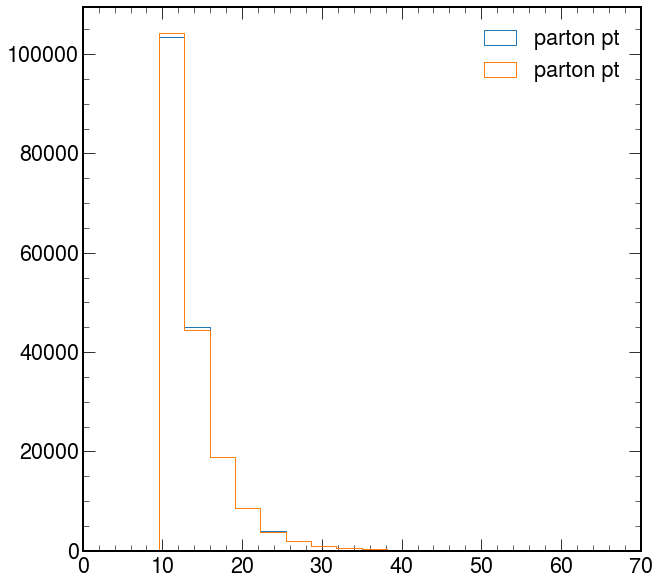





Partonptcounts =  [     1      0      0 103462  45135  18840   8523   3926   1971   1061
    604    448    240    146    112     55     56     56     27     42
     26     14]
PartonPartonptcounts.shape =  (22,)
Partonptcounts =  [     1      0      0 103462  45135  18840   8523   3926   1971   1061
    604    448    240    146    112     55     56     56     27     42
     26     14]
Partonptcounts.shape =  (22,)

Partonptedges.shape = (23,)

Partonptcenters.shape = (22,)


/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


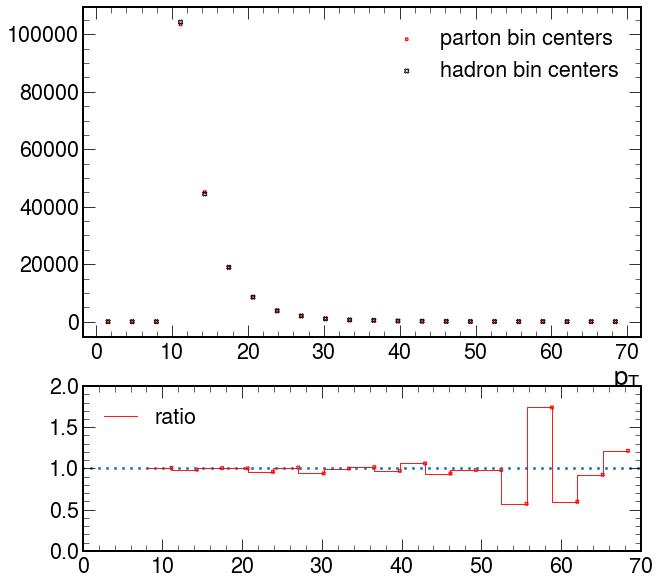

In [76]:
with uproot.open('Jetsoutput.root') as file:
    print('file keys', file.keys())
    tree = file["tree"]
    print()
    print('ttree keys',tree.keys())
    print()
    print('tree["numJetsParton"] =',tree["numJetsParton"])
    print()
    print('tree.show() = ', tree.show())
    # numJets = tree["numJetsParton"].array(library="np")
    Partonpt, Hadronpt = tree.arrays(["pTPartonJets","pTHadronJets"], outputtype = tuple)
    # pt_part = pt["pTPartonJets"]
    # pt_had = pt["pTHadronJets"]
    print('Partonpt=', Partonpt)
    print('Partonpt.shape=', Partonpt.shape)
    print('Hadrononpt.shape=', Hadronpt.shape)

    
    r=(0,70)
    b=22
    
    plt.xlim(r)
    plt.hist(Partonpt,bins=b, label='parton pt',range=r,histtype='step',rwidth=0.8)
    
    plt.hist(Hadronpt,bins=b, label='parton pt',range=r,histtype='step',rwidth=0.8)
    
    plt.legend()
    
    
    plt.show()
    
    print('\n\n\n')
    Partonptcounts, Partonptedges = np.histogram(Partonpt, bins=b, range=r)
    Hadronptcounts, Hadronptedges = np.histogram(Hadronpt, bins=b, range=r)

    print('Partonptcounts = ', Partonptcounts)
    print('PartonPartonptcounts.shape = ', Partonptcounts.shape)
    
    
    Partonptcenters = (Partonptedges[1:]+Partonptedges[:-1])/2
    Hadronptcenters = (Hadronptedges[1:]+Hadronptedges[:-1])/2
    
    print('Partonptcounts = ', Partonptcounts)
    
    print('Partonptcounts.shape = ', Partonptcounts.shape)
    print('\nPartonptedges.shape =' , Partonptedges.shape)
    print('\nPartonptcenters.shape =' , Partonptcenters.shape)

    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'height_ratios': [2,1]})


    ax1.scatter(Partonptcenters, Partonptcounts, label='parton bin centers',
            color="r",facecolors='none', marker="X", s=10, linewidth=0.9)
    
    ax1.scatter(Hadronptcenters, Hadronptcounts, label='hadron bin centers', 
                color="k",facecolors='none', marker="X", s=20, linewidth=0.9)

    
    ax1.set_xlabel(r'$p_T$')
    ax1.legend()
    
    ratio = Hadronptcounts/Partonptcounts
    
    ax2.scatter(Partonptcenters, ratio,
            color="r",facecolors='none', marker="X", s=12, linewidth=0.9)
    ax2.step(Partonptcenters, ratio, label='ratio',
            color="r",   linewidth=0.9)
    
    ax2.set_xlim(r)
    ax2.set_ylim((0,1.8))
    # ticks=np.linspace(0, 1.7, 4)
    ticks=[0,0.5,1,1.5,2]
    ax2.set_yticks(ticks)
    ones=np.linspace(0,100, num=100)
    
    ax2.scatter(ones, np.ones(100), marker="o", s=5,linewidth=0.7)
    ax2.legend(loc='upper left')

In [ ]:
with uproot.open('NoMPI_from_Status_30s_Jetsoutput.root') as file:
    print('file keys', file.keys())
    tree = file["tree"]
    print()
    print('ttree keys',tree.keys())
    print()
    print('tree["numJetsParton"] =',tree["numJetsParton"])
    print()
    print('tree.show() = ', tree.show())
    # numJets = tree["numJetsParton"].array(library="np")
    Partonpt, Hadronpt = tree.arrays(["pTPartonJets","pTHadronJets"], outputtype = tuple)
    # pt_part = pt["pTPartonJets"]
    # pt_had = pt["pTHadronJets"]
    print('Partonpt=', Partonpt)
    print('Partonpt.shape=', Partonpt.shape)
    print('Hadrononpt.shape=', Hadronpt.shape)

    
    r=(0,70)
    b=22
    
    Partonptcounts, Partonptedges = np.histogram(Partonpt, bins=b, range=r)
    Hadronptcounts, Hadronptedges = np.histogram(Hadronpt, bins=b, range=r)

    print('Partonptcounts = ', Partonptcounts)
    print('PartonPartonptcounts.shape = ', Partonptcounts.shape)
    
    
    Partonptcenters = (Partonptedges[1:]+Partonptedges[:-1])/2
    Hadronptcenters = (Hadronptedges[1:]+Hadronptedges[:-1])/2
    
    print('Partonptcounts = ', Partonptcounts)
    
    print('Partonptcounts.shape = ', Partonptcounts.shape)
    print('\nPartonptedges.shape =' , Partonptedges.shape)
    print('\nPartonptcenters.shape =' , Partonptcenters.shape)

    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'height_ratios': [2,1]})


    ax1.scatter(Partonptcenters, Partonptcounts, label='parton bin centers',
            color="r",facecolors='none', marker="X", s=10, linewidth=0.9)
    
    ax1.scatter(Hadronptcenters, Hadronptcounts, label='hadron bin centers', 
                color="k",facecolors='none', marker="X", s=20, linewidth=0.9)

    
    ax1.set_xlabel(r'$p_T$')
    ax1.legend()
    
    ratio = Hadronptcounts/Partonptcounts
    
    ax2.scatter(Partonptcenters, ratio,
            color="r",facecolors='none', marker="X", s=12, linewidth=0.9)
    ax2.step(Partonptcenters, ratio, label='ratio',
            color="r",   linewidth=0.9)
    
    ax2.set_xlim(r)
    ax2.set_ylim((0,1.8))
    # ticks=np.linspace(0, 1.7, 4)
    ticks=[0,0.5,1,1.5,2]
    ax2.set_yticks(ticks)
    ones=np.linspace(0,100, num=100)
    
    ax2.scatter(ones, np.ones(100), marker="o", s=5,linewidth=0.7)
    ax2.legend(loc='upper left')